In [1]:
import pathlib
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from gest_arch import GestData, GestPretrained, prepare, augment

from sklearn.model_selection import StratifiedKFold, train_test_split
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


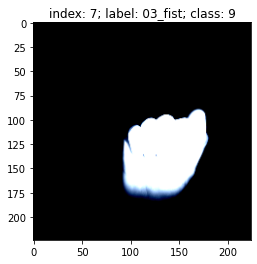

In [2]:
# collect dataset
dataset = GestData('data', fmask='*/*/*', transform=prepare, augment=augment, seed=19)
dataset.overview(7, figsize=(5, 5))

In [4]:
BATCH_SIZE = 64
EPOCHS = 3
TRAINED_LAYERS = 2

# just in case
torch.manual_seed(11)
torch.cuda.empty_cache()

# init model
model = GestPretrained(len(dataset.classes), N=TRAINED_LAYERS).to(device)

# prepare optimizer, loss function and metric
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

In [5]:
def validate_accuracy(model, loader, *, prefix='--'):
    model.eval()
    pbar = tqdm(enumerate(loader), total=len(loader), desc=f'[{prefix}] validation')
    cumulative_loss, positives = 0, 0
    for i, batch in pbar:
        inputs, labels = batch[0].to(device), batch[1].to(device)
        outputs = model(inputs)
        cumulative_loss += criterion(outputs, labels).detach().cpu().item()
        positives += (outputs.argmax(dim=1) == labels).sum().item()

        if i + 1 == len(loader):
            datalen = len(loader.dataset)
            report = {
                'cumulative loss per item': round(cumulative_loss / datalen, 4),
                'accuracy': round(positives / datalen, 4)
            }
            pbar.set_postfix(report)

In [6]:
# решил попробовать немного другой подход к формированию даталоадеров обучения:
# на каждой эпохе генерится свой набор обучающих данных (по мотивам кросс-валидации) с сохранением баланса классов
# в конце эпохи рассчитываются итоговые метрики
# добавлено: таки добавил дополнительно отложенную валидацию - мне кажется, так красивее

# формируем отложенную выборку из индексов
split_train_idx, split_valid_idx = train_test_split(np.arange(len(dataset)), test_size=0.2, stratify=dataset.labels, shuffle=True, random_state=17)
train_part = dataset.partition(split_train_idx)
valid_part = dataset.partition(split_valid_idx)

# run
skf = StratifiedKFold(n_splits=EPOCHS)
for ep, (train_idx, valid_idx) in enumerate(skf.split(train_part.collection, train_part.labels)):
    # prepare data loaders
    fold_train_loader = torch.utils.data.DataLoader(train_part.partition(train_idx), batch_size=BATCH_SIZE, shuffle=True)
    fold_valid_loader = torch.utils.data.DataLoader(train_part.partition(valid_idx), batch_size=BATCH_SIZE, shuffle=False)
    split_valid_loader = torch.utils.data.DataLoader(valid_part, batch_size=BATCH_SIZE, shuffle=False)
    
    # fit
    model.train()
    cumulative_loss, items = 0, 0
    epoch_bar = tqdm(fold_train_loader, total=len(fold_train_loader), desc=f'Train epoch {ep + 1}/{EPOCHS}')
    for batch in epoch_bar:
        inputs, labels = batch[0].to(device), batch[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        cumulative_loss += loss.item()
        items += len(labels)

        epoch_bar.set_postfix({'current cumulative loss per item': round(cumulative_loss / items, 4)})

    # validation
    validate_accuracy(model, fold_valid_loader, prefix='FOLD VALID')
    validate_accuracy(model, split_valid_loader, prefix='SPLIT VALID')

torch.save(model, f'N{TRAINED_LAYERS}_gest_detector.torchmodel')

[SPLIT VALID] validation: 100%|██████████| 63/63 [00:29<00:00,  2.14it/s, cumulative loss per item=0.0249, accuracy=0.973]


In [14]:
# check on random dataset item
model = torch.load('N2_gest_detector.torchmodel')
model.eval()

idx = np.random.default_rng().integers(len(dataset))
img, tlb = dataset[idx]
# подготовка и предикт
outputs = model(img.reshape(1, *img.shape).to(device))
label = outputs.detach().cpu().argmax(dim=1).item()

tlb, tlb, dataset.decode_class[tlb]

(6, 6, '10_down')

## LIVE webcam filter

In [3]:
def increase_brightness(img, value=30):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

In [8]:
# LIVE webcam filtering + prediction
def nothing(args):
    pass

model = torch.load('N2_gest_detector.torchmodel')
model.eval()

processing = True
capture = cv2.VideoCapture(0)
if capture.isOpened():
    rval, frame = capture.read()
else:
    rval = False

cv2.namedWindow("setup")
cv2.createTrackbar("h1", "setup", 0, 255, nothing)
cv2.createTrackbar("s1", "setup", 0, 255, nothing)
cv2.createTrackbar("v1", "setup", 0, 255, nothing)
cv2.createTrackbar("h2", "setup", 255, 255, nothing)
cv2.createTrackbar("s2", "setup", 255, 255, nothing)
cv2.createTrackbar("v2", "setup", 255, 255, nothing)
while rval and processing:
    h1 = cv2.getTrackbarPos('h1', 'setup')
    s1 = cv2.getTrackbarPos('s1', 'setup')
    v1 = cv2.getTrackbarPos('v1', 'setup')
    h2 = cv2.getTrackbarPos('h2', 'setup')
    s2 = cv2.getTrackbarPos('s2', 'setup')
    v2 = cv2.getTrackbarPos('v2', 'setup')
    min_p = (h1, s1, v1)
    max_p = (h2, s2, v2)
    # БДСМ имитация инфракрасной камеры
    # frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    kernel = 5
    frame = cv2.blur(frame, (kernel, kernel))
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2RGB)
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2HSV)
    kernel = 5
    frame = cv2.blur(frame, (kernel, kernel))

    frame = increase_brightness(frame, 40)
    # apply mask
    mask = cv2.inRange(frame, min_p, max_p)
    frame = cv2.bitwise_and(frame, frame, mask=mask)
    frame = cv2.cvtColor(frame, cv2.COLOR_HSV2RGB)

    frame_tensor = prepare(frame)
    cv2.imshow("preview", frame_tensor.permute(1, 2, 0).numpy())

    # get next frame
    rval, frame = capture.read()
    key = cv2.waitKey(50)
    if (key & 0xFF == ord('q')) or key == 27:
        processing = False
    elif key == 32:
        # подготовка и предикт        
        outputs = model(frame_tensor.reshape(1, *frame_tensor.shape).to(device))
        label = outputs.detach().cpu().argmax(dim=1).item()
        print(f'Detected gesture index: {dataset.decode_class[label]}')

capture.release()
cv2.destroyAllWindows()

QObject::moveToThread: Current thread (0x55ec63a39cf0) is not the object's thread (0x55ec649098e0).
Cannot move to target thread (0x55ec63a39cf0)

QObject::moveToThread: Current thread (0x55ec63a39cf0) is not the object's thread (0x55ec649098e0).
Cannot move to target thread (0x55ec63a39cf0)

QObject::moveToThread: Current thread (0x55ec63a39cf0) is not the object's thread (0x55ec649098e0).
Cannot move to target thread (0x55ec63a39cf0)

QObject::moveToThread: Current thread (0x55ec63a39cf0) is not the object's thread (0x55ec649098e0).
Cannot move to target thread (0x55ec63a39cf0)

QObject::moveToThread: Current thread (0x55ec63a39cf0) is not the object's thread (0x55ec649098e0).
Cannot move to target thread (0x55ec63a39cf0)

QObject::moveToThread: Current thread (0x55ec63a39cf0) is not the object's thread (0x55ec649098e0).
Cannot move to target thread (0x55ec63a39cf0)

QObject::moveToThread: Current thread (0x55ec63a39cf0) is not the object's thread (0x55ec649098e0).
Cannot move to tar

Detected gesture index: 01_palm
Detected gesture index: 10_down
Detected gesture index: 06_index
Detected gesture index: 01_palm
Detected gesture index: 01_palm
Detected gesture index: 01_palm
Detected gesture index: 01_palm
Detected gesture index: 01_palm
Detected gesture index: 01_palm
Detected gesture index: 09_c
Detected gesture index: 10_down
Detected gesture index: 07_ok


In [ ]:
#